In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs

np.random.seed(1234)

In [2]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.current_device())  # Should return an integer (GPU index)
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # GPU name

True
0
NVIDIA GeForce RTX 2060


In [3]:
# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")

torch.backends.cudnn.benchmark = True

Using device: cuda


In [4]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        modules = []
        for i in range(len(layers) - 2):  # Exclude last layer for activation
            modules.append(nn.Linear(layers[i], layers[i+1]))
            modules.append(nn.Tanh())
        modules.append(nn.Linear(layers[-2], layers[-1]))  # Last layer (no activation)
        self.network = nn.Sequential(*modules)

        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.network(x)

In [5]:
lbfgs_lr = 0.0005
adam_lr = 0.001

In [29]:
class PINN():
    def __init__(self, X, Y, layers, s0, E, h, l, r, nu):
        self.x_dom = torch.tensor(X['dom'], requires_grad=True).float().to(device).view(-1, 1)
        self.y_dom = torch.tensor(Y['dom'], requires_grad=True).float().to(device).view(-1, 1)

        self.x_left = torch.tensor(X['left'], requires_grad=True).float().to(device).view(-1, 1)
        self.y_left = torch.tensor(Y['left'], requires_grad=True).float().to(device).view(-1, 1)
        
        self.x_top = torch.tensor(X['top'], requires_grad=True).float().to(device).view(-1, 1)
        self.y_top = torch.tensor(Y['top'], requires_grad=True).float().to(device).view(-1, 1)

        self.x_right = torch.tensor(X['right'], requires_grad=True).float().to(device).view(-1, 1)
        self.y_right = torch.tensor(Y['right'], requires_grad=True).float().to(device).view(-1, 1)

        self.x_down = torch.tensor(X['down'], requires_grad=True).float().to(device).view(-1, 1)
        self.y_down = torch.tensor(Y['down'], requires_grad=True).float().to(device).view(-1, 1)

        self.x_hole = torch.tensor(X['hole'], requires_grad=True).float().to(device).view(-1, 1)
        self.y_hole = torch.tensor(Y['hole'], requires_grad=True).float().to(device).view(-1, 1)

        self.s_r = s0
        self.E = E
        self.nu = nu

        self.h = h
        self.l = l
        self.r = r

        self.w_pde = 1
        self.w_bc = 1

        # DNN
        self.dnn = DNN(layers).to(device)

        # Optimizer
        self.optimizer_lbfgs = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=lbfgs_lr,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=adam_lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer_adam, step_size=2000, gamma=0.5)
        self.iter = 0

    def model_value(self, x, y):
        out = self.dnn(torch.cat((x, y), dim=1))
        u = out[:,0].view(-1, 1)
        v = out[:,1].view(-1, 1)
        sxx = out[:,2].view(-1, 1)
        syy = out[:,3].view(-1, 1)
        sxy = out[:,4].view(-1, 1)
        return u, v, sxx, syy, sxy

    def pde_loss(self, x, y):
        u, v, sxx, syy, sxy = self.model_value(x, y)

        dx_u = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        dy_u = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
        dx_v = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
        dy_v = torch.autograd.grad(v, y, torch.ones_like(v), create_graph=True)[0]

        dx_sxx = torch.autograd.grad(sxx, x, torch.ones_like(sxx), create_graph=True)[0]
        dy_syy = torch.autograd.grad(syy, y, torch.ones_like(syy), create_graph=True)[0]
        dy_sxy = torch.autograd.grad(sxy, y, torch.ones_like(sxy), create_graph=True)[0]
        dx_sxy = torch.autograd.grad(sxy, x, torch.ones_like(sxy), create_graph=True)[0]

        term_xx = self.E / (1 - self.nu**2) * (dx_u + self.nu*dy_v)
        term_yy = self.E / (1 - self.nu**2) * (dy_v + self.nu*dx_u)
        term_xy = self.E / (2*(1 + self.nu)) * (dy_u + dx_v)

        r1 = torch.mean(torch.pow((sxx - term_xx), 2))
        r2 = torch.mean(torch.pow((syy - term_yy), 2))
        r3 = torch.mean(torch.pow((sxy - term_xy), 2))
        r4 = torch.mean(torch.pow((dx_sxx + dy_sxy), 2))
        r5 = torch.mean(torch.pow((dy_syy + dx_sxy), 2))

        residual = r1 + r2+ r3 + r4 + r5
        return residual

    def bc_loss(self, xl, yl, xt, yt, xr, yr, xd, yd, xh, yh):
        u_l, v_l, _, _, _ = self.model_value(xl, yl)
        _, _, _, syy_t, sxy_t = self.model_value(xt, yt)
        _, _, sxx_r, _, sxy_r = self.model_value(xr, yr)
        _, v_d, _, syy_d, sxy_d = self.model_value(xd, yd)
        _, _, sxx_h, syy_h, sxy_h = self.model_value(xh, yh)

        b = torch.mean(torch.pow(u_l, 2))

        b += torch.mean(torch.pow(syy_t, 2))
        b += torch.mean(torch.pow(sxy_t, 2))

        b += torch.mean(torch.pow(sxx_r - self.s_r, 2))
        b += torch.mean(torch.pow(sxy_r, 2))

        b += torch.mean(torch.pow(v_d, 2))

        n = -1 * torch.stack([(xh)/self.r, (yh)/self.r], dim=1)
        s = torch.cat([
            torch.cat([sxx_h, sxy_h], dim=1).unsqueeze(1),  # First row (xx, xy)
            torch.cat([sxy_h, syy_h], dim=1).unsqueeze(1)   # Second row (xy, yy)
        ], dim=1)

        t = torch.bmm(s, n)
        b += torch.mean(torch.pow(t, 2))

        return b

    
    def loss_func(self):
        pde = self.pde_loss(self.x_dom, self.y_dom)
        bc = self.bc_loss(
            self.x_left, self.y_left, 
            self.x_top, self.y_top, 
            self.x_right, self.y_right, 
            self.x_down, self.y_down, 
            self.x_hole, self.y_hole
        )

        return pde, bc


    def lbfgs_func(self):
        pde_loss, bc_loss = self.loss_func()
        loss = self.w_pde*pde_loss + self.w_bc*bc_loss
        self.optimizer_lbfgs.zero_grad()
        loss.backward()

        if self.iter % 100 == 0:
            print(f"Iter: {self.iter}, Loss: {'{:e}'.format(loss.item())}")
        self.iter += 1
        return loss
    
    def train(self, epochs=1000):
        self.dnn.train()
        for epoch in range(epochs):
            pde_loss, bc_loss = self.loss_func()
            loss = self.w_pde*pde_loss + self.w_bc*bc_loss

            self.optimizer_adam.zero_grad()
            loss.backward()
            self.optimizer_adam.step()
            self.scheduler.step()

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {'{:e}'.format(loss.item())}")
                print(f"PDE: {'{:e}'.format(pde_loss.item())}, BC: {'{:e}'.format(bc_loss.item())}")
        self.optimizer_lbfgs.step(self.lbfgs_func)

    def predict(self, x, y):
        x = torch.tensor(x).float().to(device)
        y = torch.tensor(y).float().to(device)

        self.dnn.eval()
        u, v, sxx, syy, sxy = self.model_value(x, y)
        u = u.detach().cpu().numpy()
        v = v.detach().cpu().numpy()
        sxx = sxx.detach().cpu().numpy()
        syy = syy.detach().cpu().numpy()
        sxy = sxy.detach().cpu().numpy()
        return u, v, sxx, syy, sxy

In [48]:
def generate_points(pd, pb, l, h, r):
    a = 0
    b = 0

    area = r**2 * np.pi
    p_new = int(pd * (1+area)) # Increase amount of points with percantage of circle covering

    dom = lhs(2, p_new) * 0.4
    mask = np.sqrt((dom[:,0]*l - a)**2 + (dom[:,1]*h - b)**2) >= r
    dom = dom[mask]
    dom2 = lhs(2, int(p_new/10))
    mask2 = np.sqrt((dom2[:,0]*l - a)**2 + (dom2[:,1]*h - b)**2) >= r
    dom2 = dom2[mask2]
    dom_x = dom[:,0] * l
    dom_y = dom[:,1] * h
    
    dom_x = np.append(dom_x, dom2[:,0])
    dom_y = np.append(dom_y, dom2[:,1])

    left_x = np.zeros(pb)
    left_y = lhs(1, pb) * (h-r) + r

    top_x = lhs(1, pb) * l
    top_y = np.ones(pb) * h

    right_x = np.ones(pb) * l
    right_y = lhs(1, pb) * h

    down_x = lhs(1, pb) * (l-r) + r
    down_y = np.zeros(pb)

    theta = np.random.uniform(0, np.pi/2, pb)
    hole_x = a + r*np.cos(theta)
    hole_y = b + r*np.sin(theta)

    X = {'dom': dom_x, 'left': left_x, 'top': top_x, 'right': right_x, 'down': down_x, 'hole': hole_x}
    Y = {'dom': dom_y, 'left': left_y, 'top': top_y, 'right': right_y, 'down': down_y, 'hole': hole_y}
    return X, Y

In [52]:
l = 1
h = 1
r = 0.2
s0 = 0.1
E = 1
nu = 0.3


X, Y = generate_points(50000, 1000, l, h, r)

nodes = 80
layers = [2] + 8 * [nodes] + [5]

In [53]:
model = PINN(X, Y, layers, s0, E, h, l, r, nu)

In [54]:
model.train(5000)

Epoch 0, Loss: 7.398628e-02
PDE: 3.935293e-02, BC: 3.463335e-02
Epoch 100, Loss: 1.216425e-03
PDE: 1.848126e-04, BC: 1.031612e-03
Epoch 200, Loss: 1.162798e-03
PDE: 1.671587e-04, BC: 9.956391e-04
Epoch 300, Loss: 1.097371e-03
PDE: 1.585193e-04, BC: 9.388519e-04
Epoch 400, Loss: 1.015103e-03
PDE: 1.535158e-04, BC: 8.615874e-04
Epoch 500, Loss: 9.143653e-04
PDE: 1.601036e-04, BC: 7.542617e-04
Epoch 600, Loss: 8.076755e-04
PDE: 1.897304e-04, BC: 6.179452e-04
Epoch 700, Loss: 7.231223e-04
PDE: 2.351514e-04, BC: 4.879708e-04
Epoch 800, Loss: 6.640038e-04
PDE: 2.623137e-04, BC: 4.016901e-04
Epoch 900, Loss: 8.823752e-04
PDE: 4.995418e-04, BC: 3.828334e-04
Epoch 1000, Loss: 5.999607e-04
PDE: 2.650365e-04, BC: 3.349242e-04
Epoch 1100, Loss: 5.477979e-04
PDE: 2.731663e-04, BC: 2.746316e-04
Epoch 1200, Loss: 4.301575e-03
PDE: 2.907013e-03, BC: 1.394562e-03
Epoch 1300, Loss: 5.970803e-04
PDE: 2.345290e-04, BC: 3.625514e-04
Epoch 1400, Loss: 5.158936e-04
PDE: 2.514485e-04, BC: 2.644451e-04
Epoch 1

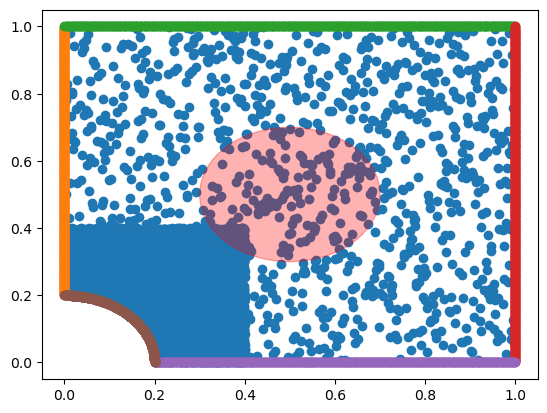

In [50]:
circle = plt.Circle((l/2, h/2), r, color='red', alpha=0.3)


figure, ax = plt.subplots()
ax.scatter(X['dom'], Y['dom'])
ax.scatter(X['left'], Y['left'])
ax.scatter(X['top'], Y['top'])
ax.scatter(X['right'], Y['right'])
ax.scatter(X['down'], Y['down'])
ax.scatter(X['hole'], Y['hole'])

ax.add_patch(circle)

plt.show()

In [55]:
x1, y1 = generate_points(10000, 500, l, h, r)

x = x1['left']
x = np.append(x, x1['right'])
x = np.append(x, x1['top'])
x = np.append(x, x1['down'])
x = np.append(x, x1['hole'])
x = np.append(x, x1['dom'])
x = x.reshape(-1, 1)

y = y1['left']
y = np.append(y, y1['right'])
y = np.append(y, y1['top'])
y = np.append(y, y1['down'])
y = np.append(y, y1['hole'])
y = np.append(y, y1['dom'])
y = y.reshape(-1, 1)

print(y.shape)
print(x.shape)

u, v, sxx, syy, sxy = model.predict(x, y)

(12642, 1)
(12642, 1)


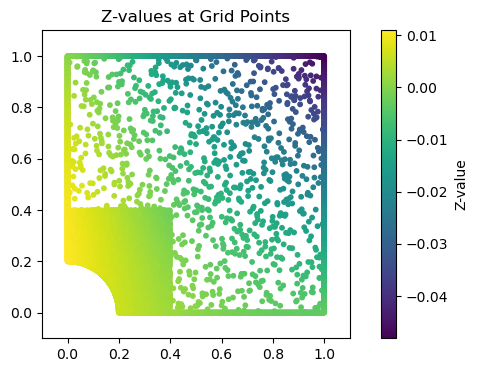

In [60]:
plt.figure(figsize=(8, 4))
sc = plt.scatter(x, y, c=v, cmap='viridis', s=10)
plt.colorbar(sc, label="Z-value")
plt.title("Z-values at Grid Points")
plt.xlim(-0.1, 0.1+l)
plt.ylim(-0.1, h+0.1)
plt.gca().set_aspect('equal')
plt.show()